In [ ]:
# Some standard imports
import io
import numpy as np

from torch import nn
import torch.utils.model_zoo as model_zoo
import torch.onnx

In [ ]:
cd /content/drive/MyDrive/CS3033 Final Project/torch/models

/content/drive/MyDrive/CS3033 Final Project/torch/models


In [ ]:
import math
import torch
import torch.nn as nn
from splat import SplAtConv2d, DropBlock2D
#from build import RESNEST_MODELS_REGISTRY

# Deployment Preparation: 


## Step1: ResNeSt framework (basic block) for loading model 

In [ ]:
class BasicBlock(nn.Module):
    """ResNet BasicBlock
    """
    # pylint: disable=unused-argument
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 radix=1, cardinality=1, bottleneck_width=64,
                 avd=False, avd_first=False, dilation=1, is_first=False,
                 rectified_conv=False, rectify_avg=False,
                 norm_layer=None, dropblock_prob=0.0, last_gamma=False):
        super(BasicBlock, self).__init__()
        group_width = int(planes * (bottleneck_width / 64.)) * cardinality
        self.conv1 = nn.Conv2d(inplanes, group_width, kernel_size=3, padding=1, bias=False)
        self.bn1 = norm_layer(group_width)
        self.dropblock_prob = dropblock_prob
        self.radix = radix
        self.avd = avd and (stride > 1 or is_first)
        self.avd_first = avd_first

        if self.avd:
            self.avd_layer = nn.AvgPool2d(3, stride, padding=1)
            stride = 1

        if dropblock_prob > 0.0:
            self.dropblock1 = DropBlock2D(dropblock_prob, 3)
            if radix == 1:
                self.dropblock2 = DropBlock2D(dropblock_prob, 3)
            self.dropblock3 = DropBlock2D(dropblock_prob, 3)

        if radix >= 1:
            self.conv2 = SplAtConv2d(
                group_width, group_width, kernel_size=3,
                stride=stride, padding=dilation,
                dilation=dilation, groups=cardinality, bias=False,
                radix=radix, rectify=rectified_conv,
                rectify_avg=rectify_avg,
                norm_layer=norm_layer,
                dropblock_prob=dropblock_prob)
        elif rectified_conv:
            from rfconv import RFConv2d
            self.conv2 = RFConv2d(
                group_width, group_width, kernel_size=3, stride=stride,
                padding=dilation, dilation=dilation,
                groups=cardinality, bias=False,
                average_mode=rectify_avg)
            self.bn2 = norm_layer(group_width)
        else:
            self.conv2 = nn.Conv2d(
                group_width, group_width, kernel_size=3, stride=stride,
                padding=dilation, dilation=dilation,
                groups=cardinality, bias=False)
            self.bn2 = norm_layer(group_width)

        # self.conv3 = nn.Conv2d(
        #     group_width, planes * 4, kernel_size=1, bias=False)
        # self.bn3 = norm_layer(planes*4)

        if last_gamma:
            from torch.nn.init import zeros_
            zeros_(self.bn3.weight)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.dilation = dilation
        self.stride = stride     


    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        if self.dropblock_prob > 0.0:
            out = self.dropblock1(out)
        out = self.relu(out)

        if self.avd and self.avd_first:
            out = self.avd_layer(out)

        out = self.conv2(out)
        if self.radix == 0:
            out = self.bn2(out)
            if self.dropblock_prob > 0.0:
                out = self.dropblock2(out)
            out = self.relu(out)

        if self.avd and not self.avd_first:
            out = self.avd_layer(out)

        # out = self.conv3(out)
        # out = self.bn3(out)
        if self.dropblock_prob > 0.0:
            out = self.dropblock3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [ ]:
class GlobalAvgPool2d(nn.Module):
    def __init__(self):
        """Global average pooling over the input's spatial dimensions"""
        super(GlobalAvgPool2d, self).__init__()

    def forward(self, inputs):
        return nn.functional.adaptive_avg_pool2d(inputs, 1).view(inputs.size(0), -1)

class Bottleneck(nn.Module):
    """ResNet Bottleneck
    """
    # pylint: disable=unused-argument
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 radix=1, cardinality=1, bottleneck_width=64,
                 avd=False, avd_first=False, dilation=1, is_first=False,
                 rectified_conv=False, rectify_avg=False,
                 norm_layer=None, dropblock_prob=0.0, last_gamma=False):
        super(Bottleneck, self).__init__()
        group_width = int(planes * (bottleneck_width / 64.)) * cardinality
        self.conv1 = nn.Conv2d(inplanes, group_width, kernel_size=1, bias=False)
        self.bn1 = norm_layer(group_width)
        self.dropblock_prob = dropblock_prob
        self.radix = radix
        self.avd = avd and (stride > 1 or is_first)
        self.avd_first = avd_first

        if self.avd:
            self.avd_layer = nn.AvgPool2d(3, stride, padding=1)
            stride = 1

        if dropblock_prob > 0.0:
            self.dropblock1 = DropBlock2D(dropblock_prob, 3)
            if radix == 1:
                self.dropblock2 = DropBlock2D(dropblock_prob, 3)
            self.dropblock3 = DropBlock2D(dropblock_prob, 3)

        if radix >= 1:
            self.conv2 = SplAtConv2d(
                group_width, group_width, kernel_size=3,
                stride=stride, padding=dilation,
                dilation=dilation, groups=cardinality, bias=False,
                radix=radix, rectify=rectified_conv,
                rectify_avg=rectify_avg,
                norm_layer=norm_layer,
                dropblock_prob=dropblock_prob)
        elif rectified_conv:
            from rfconv import RFConv2d
            self.conv2 = RFConv2d(
                group_width, group_width, kernel_size=3, stride=stride,
                padding=dilation, dilation=dilation,
                groups=cardinality, bias=False,
                average_mode=rectify_avg)
            self.bn2 = norm_layer(group_width)
        else:
            self.conv2 = nn.Conv2d(
                group_width, group_width, kernel_size=3, stride=stride,
                padding=dilation, dilation=dilation,
                groups=cardinality, bias=False)
            self.bn2 = norm_layer(group_width)

        self.conv3 = nn.Conv2d(
            group_width, planes * 4, kernel_size=1, bias=False)
        self.bn3 = norm_layer(planes*4)

        if last_gamma:
            from torch.nn.init import zeros_
            zeros_(self.bn3.weight)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.dilation = dilation
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        if self.dropblock_prob > 0.0:
            out = self.dropblock1(out)
        out = self.relu(out)

        if self.avd and self.avd_first:
            out = self.avd_layer(out)

        out = self.conv2(out)
        if self.radix == 0:
            out = self.bn2(out)
            if self.dropblock_prob > 0.0:
                out = self.dropblock2(out)
            out = self.relu(out)

        if self.avd and not self.avd_first:
            out = self.avd_layer(out)

        out = self.conv3(out)
        out = self.bn3(out)
        if self.dropblock_prob > 0.0:
            out = self.dropblock3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    """ResNet Variants
    Parameters
    ----------
    block : Block
        Class for the residual block. Options are BasicBlockV1, BottleneckV1.
    layers : list of int
        Numbers of layers in each block
    classes : int, default 1000
        Number of classification classes.
    dilated : bool, default False
        Applying dilation strategy to pretrained ResNet yielding a stride-8 model,
        typically used in Semantic Segmentation.
    norm_layer : object
        Normalization layer used in backbone network (default: :class:`mxnet.gluon.nn.BatchNorm`;
        for Synchronized Cross-GPU BachNormalization).
    Reference:
        - He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.
        - Yu, Fisher, and Vladlen Koltun. "Multi-scale context aggregation by dilated convolutions."
    """
    # pylint: disable=unused-variable
    def __init__(self, block, layers, radix=1, groups=1, bottleneck_width=64,
                 num_classes=1000, dilated=False, dilation=1,
                 deep_stem=False, stem_width=64, avg_down=False,
                 rectified_conv=False, rectify_avg=False,
                 avd=False, avd_first=False,
                 final_drop=0.0, dropblock_prob=0,
                 last_gamma=False, norm_layer=nn.BatchNorm2d):

        self.cardinality = groups
        self.bottleneck_width = bottleneck_width
        # ResNet-D params
        self.inplanes = stem_width*2 if deep_stem else 64
        self.avg_down = avg_down
        self.last_gamma = last_gamma
        # ResNeSt params
        self.radix = radix
        self.avd = avd
        self.avd_first = avd_first

        super(ResNet, self).__init__()
        self.rectified_conv = rectified_conv
        self.rectify_avg = rectify_avg
        if rectified_conv:
            from rfconv import RFConv2d
            conv_layer = RFConv2d
        else:
            conv_layer = nn.Conv2d
        conv_kwargs = {'average_mode': rectify_avg} if rectified_conv else {}
        if deep_stem:
            self.conv1 = nn.Sequential(
                conv_layer(3, stem_width, kernel_size=3, stride=2, padding=1, bias=False, **conv_kwargs),
                norm_layer(stem_width),
                nn.ReLU(inplace=True),
                conv_layer(stem_width, stem_width, kernel_size=3, stride=1, padding=1, bias=False, **conv_kwargs),
                norm_layer(stem_width),
                nn.ReLU(inplace=True),
                conv_layer(stem_width, stem_width*2, kernel_size=3, stride=1, padding=1, bias=False, **conv_kwargs),
            )
        else:
            self.conv1 = conv_layer(3, 64, kernel_size=7, stride=2, padding=3,
                                   bias=False, **conv_kwargs)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], norm_layer=norm_layer, is_first=False)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, norm_layer=norm_layer)
        if dilated or dilation == 4:
            self.layer3 = self._make_layer(block, 256, layers[2], stride=1,
                                           dilation=2, norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
            self.layer4 = self._make_layer(block, 512, layers[3], stride=1,
                                           dilation=4, norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
        elif dilation==2:
            self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                           dilation=1, norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
            self.layer4 = self._make_layer(block, 512, layers[3], stride=1,
                                           dilation=2, norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
        else:
            self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                           norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
            self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                           norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
        self.avgpool = GlobalAvgPool2d()
        self.drop = nn.Dropout(final_drop) if final_drop > 0.0 else None
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, norm_layer):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1, norm_layer=None,
                    dropblock_prob=0.0, is_first=True):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            down_layers = []
            if self.avg_down:
                if dilation == 1:
                    down_layers.append(nn.AvgPool2d(kernel_size=stride, stride=stride,
                                                    ceil_mode=True, count_include_pad=False))
                else:
                    down_layers.append(nn.AvgPool2d(kernel_size=1, stride=1,
                                                    ceil_mode=True, count_include_pad=False))
                down_layers.append(nn.Conv2d(self.inplanes, planes * block.expansion,
                                             kernel_size=1, stride=1, bias=False))
            else:
                down_layers.append(nn.Conv2d(self.inplanes, planes * block.expansion,
                                             kernel_size=1, stride=stride, bias=False))
            down_layers.append(norm_layer(planes * block.expansion))
            downsample = nn.Sequential(*down_layers)

        layers = []
        if dilation == 1 or dilation == 2:
            layers.append(block(self.inplanes, planes, stride, downsample=downsample,
                                radix=self.radix, cardinality=self.cardinality,
                                bottleneck_width=self.bottleneck_width,
                                avd=self.avd, avd_first=self.avd_first,
                                dilation=1, is_first=is_first, rectified_conv=self.rectified_conv,
                                rectify_avg=self.rectify_avg,
                                norm_layer=norm_layer, dropblock_prob=dropblock_prob,
                                last_gamma=self.last_gamma))
        elif dilation == 4:
            layers.append(block(self.inplanes, planes, stride, downsample=downsample,
                                radix=self.radix, cardinality=self.cardinality,
                                bottleneck_width=self.bottleneck_width,
                                avd=self.avd, avd_first=self.avd_first,
                                dilation=2, is_first=is_first, rectified_conv=self.rectified_conv,
                                rectify_avg=self.rectify_avg,
                                norm_layer=norm_layer, dropblock_prob=dropblock_prob,
                                last_gamma=self.last_gamma))
        else:
            raise RuntimeError("=> unknown dilation size: {}".format(dilation))

        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes,
                                radix=self.radix, cardinality=self.cardinality,
                                bottleneck_width=self.bottleneck_width,
                                avd=self.avd, avd_first=self.avd_first,
                                dilation=dilation, rectified_conv=self.rectified_conv,
                                rectify_avg=self.rectify_avg,
                                norm_layer=norm_layer, dropblock_prob=dropblock_prob,
                                last_gamma=self.last_gamma))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        if self.drop:
            x = self.drop(x)
        x = self.fc(x)

        return x

## Step2: Loading pytorch model for conversion

In [ ]:
cd /content/drive/MyDrive/CS3033 Final Project/results_hg

/content/drive/MyDrive/CS3033 Final Project/results_hg


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ResNet(BasicBlock, [3, 4, 14, 3],
                   radix=2, groups=1, bottleneck_width=64,num_classes=10,
                   deep_stem=True, stem_width=32, avg_down=True,
                   avd=True, avd_first=False)
model.load_state_dict(torch.load("resnest50_basic.pt",map_location=torch.device('cpu')))
model = model#.to(device)
#model.eval()

#error = evaluate(model, test_loader, device)
#print(f"accuracy = {1-error}")

In [ ]:
# import torch
# torch.cuda.empty_cache()

## Step3: Converting pytorch model to onnx and caffe2 model

In [ ]:
# Export an ONNX model from a PyTorch .pt model
import torch.onnx
# Loading the input PyTorch model and mapping the tensors to CPU
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
#model = torch.load('animals_caltech.pt', map_location=device)
# Generate a dummy input that is consistent with the network's arhitecture
dummy_input = torch.randn(1, 3, 32, 32).to(device)
# Export into an ONNX model using the PyTorch model and the dummy input
torch.onnx.export(model, dummy_input, "resnet50_basic_cpu.onnx",keep_initializers_as_inputs=True,operator_export_type=torch.onnx.OperatorExportTypes.ONNX_ATEN_FALLBACK)

/usr/local/lib/python3.7/dist-packages/torch/onnx/utils.py:264: UserWarning: `add_node_names' can be set to True only when 'operator_export_type' is `ONNX`. Since 'operator_export_type' is not set to 'ONNX', `add_node_names` argument will be ignored.
  "`{}` argument will be ignored.".format(arg_name, arg_name))
/usr/local/lib/python3.7/dist-packages/torch/onnx/utils.py:264: UserWarning: `do_constant_folding' can be set to True only when 'operator_export_type' is `ONNX`. Since 'operator_export_type' is not set to 'ONNX', `do_constant_folding` argument will be ignored.
  "`{}` argument will be ignored.".format(arg_name, arg_name))


In [ ]:
! pip install onnx==1.8.1
# ! conda install pytorch-nightly-cpu -c pytorch

     |████████████████████████████████| 14.5MB 6.4MB/s 


In [ ]:
cd /content/drive/MyDrive/CS3033 Final Project/results_hg/

/content/drive/MyDrive/CS3033 Final Project/results_hg


# Deployment of ResNeSt50 model on both frameworks:

## Part 1: Inference ResNeSt50 on caffe2 framework

### inference on single image

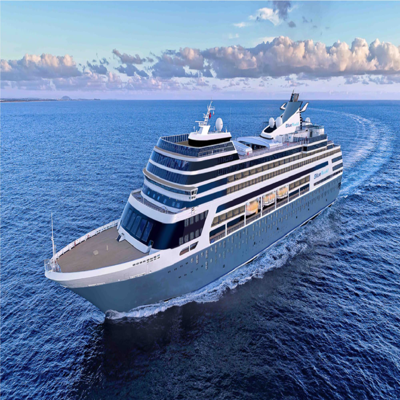

(1, 3, 32, 32)
Local CPU Inference time in MacOS using ONNX model :  0.06907343864440918
Prediction  1 : ship        , Class Id :  8  Score:  0.9948023803
Prediction  2 : hourse      , Class Id :  7  Score:  0.0021202069
Prediction  3 : dog         , Class Id :  5  Score:  0.0013184709
Prediction  4 : truck       , Class Id :  9  Score:  0.0011057975
Prediction  5 : frog        , Class Id :  6  Score:  0.0003777797
Prediction  6 : bird        , Class Id :  2  Score:  0.0002167034
Prediction  7 : airplane    , Class Id :  0  Score:  4.08939e-05
Prediction  8 : deer        , Class Id :  4  Score:  1.4758e-05
Prediction  9 : automobile  , Class Id :  1  Score:  2.7671e-06
Prediction 10 : cat         , Class Id :  3  Score:  2.422e-07


In [ ]:

# Inference in Caffe using the ONNX model

import caffe2.python.onnx.backend as backend
import onnx

from torchvision import transforms
from PIL import Image
import time
import numpy as np

# First load the onnx model
model_onnx = onnx.load("resnet50_basic_cpu.onnx")
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Prepare the backend
rep = backend.prepare(model_onnx, device= 'CPU')

# Transform the image
transform = transforms.Compose([
        transforms.Resize(size=32),
        #transforms.CenterCrop(size=32),
        transforms.ToTensor(),
        transforms.Normalize([0.4918687901200927, 0.49185976472299225, 0.4918583862227116],
                             [0.24697121702736, 0.24696766978537033, 0.2469719877121087])
    ])
          
# Load and show the image
test_image_name = "/content/drive/MyDrive/CS3033 Final Project/test_image/ship/ship2.jpg"
test_image = Image.open(test_image_name).resize((400,400))
display(test_image)

# Apply the transformations to the input image and convert it into a tensor
test_image_tensor = transform(test_image)

# Make the input image ready to be input as a batch of size 1
test_image_tensor = test_image_tensor.view(1, 3, 32, 32)

time_start = time.time()
# Convert the tensor to numpy array
np_image = test_image_tensor.numpy()
print(np_image.shape)
# Pass the numpy array to run through the ONNX model
outputs = rep.run(np_image.astype(np.float32))
time_end = time.time()
print("Local CPU Inference time in MacOS using ONNX model : ", time_end - time_start)

# Dictionary with class name and index
idx_to_class = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'hourse', 8: 'ship', 9: 'truck'}

ps = torch.exp(torch.from_numpy(outputs[0]))
topk, topclass = ps.topk(10, dim=1)
for i in range(10):
    print("Prediction", '{:2d}'.format(i+1), ":", '{:11}'.format(idx_to_class[topclass.cpu().numpy()[0][i]]), ", Class Id : ", topclass[0][i].numpy(), " Score: ",round(ss[i],10))
#topk.cpu().detach().numpy()[0]

### Inference on testsets

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
test_data = datasets.ImageFolder(root='/content/drive/MyDrive/CS3033_HW5/test', transform=transform)
test_loader = torch.utils.data.DataLoader(
        test_data, batch_size=1, shuffle=True,
        num_workers=4, pin_memory=False
    )

In [ ]:
data_dir = 'data/cifar10'
batch_size = 128

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

def get_data_loaders(data_dir,
                     batch_size,
                     train_transform,
                     test_transform,
                     shuffle=True,
                     num_workers=4,
                     pin_memory=False):
    
    # Load the datasets
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    test_dataset = datasets.CIFAR10(
        root=data_dir, train=False,
        download=True, transform=test_transform,
    )
    
    # Create loader objects
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory
    )
          
    return (train_loader, test_loader)

In [ ]:
# Normalisation parameters fo CIFAR10
means = [0.4918687901200927, 0.49185976472299225, 0.4918583862227116]
stds  = [0.24697121702736, 0.24696766978537033, 0.2469719877121087]

normalize = transforms.Normalize(
    mean=means,
    std=stds,
)

train_transform = transforms.Compose([
    # 4 pixels are padded on each side, 
    transforms.Pad(4),
    # a 32×32 crop is randomly sampled from the 
    # padded image or its horizontal flip.
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
    normalize
])

test_transform = transforms.Compose([
    # For testing, we only evaluate the single 
    # view of the original 32×32 image.
    transforms.ToTensor(),
    normalize
])
train_loader, test_loader2 = get_data_loaders(data_dir,
                                             batch_size,
                                             train_transform,
                                             test_transform,
                                             shuffle=True,
                                             num_workers=4,
                                             pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def evaluate_caffe2(model, data_loader, device):
    
    y_true = np.array([], dtype=np.int)
    y_pred = np.array([], dtype=np.int)
    times = []

    rep = backend.prepare(model_onnx, device= 'CPU')
    for data in data_loader:
        time_start = time.time()
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = rep.run(inputs.numpy().astype(np.float32))
        predicted = np.argmax(outputs[0][0])
        time_end = time.time()
        infe_time = time_end - time_start
        times.append(infe_time)

        y_true = np.concatenate((y_true, labels.cpu()))
        y_pred = np.concatenate((y_pred, [predicted]))

    avgtime = np.mean(times)
    error = np.sum(y_pred != y_true) / len(y_true)
    return error, avgtime

In [ ]:
error,avgtime = evaluate_caffe2(model_onnx, test_loader, device)
print(f"For Caffe2 framework in small testset, test accuracy = {1-error}, average inference time = {avgtime}")

For Caffe2 framework in small testset, test accuracy = 0.88, average inference time = 0.02854498863220215


In [ ]:
error2,avgtime2 = evaluate_caffe2(model_onnx, test_loader2, device)
print(f"For Caffe2 framework in large testset, test accuracy = {1-error2}, average inference time = {avgtime2}")

For Caffe2 framework in large testset, test accuracy = 0.8812, average inference time = 0.02877593517303467


## Part 2: Inference the ResNeSt50 on pytorch framework (Google cloud platform)

### Inference on single image 

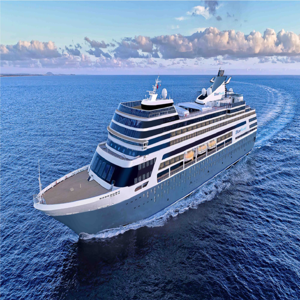

In [ ]:
# Inference in Caffe using the ONNX model
import torch
from torchvision import transforms
from PIL import Image
import time
import numpy as np

# Loading the input PyTorch model and mapping the tensors to CPU
device = torch.device('cpu')
model_torch = ResNet(BasicBlock, [3, 4, 14, 3],
                   radix=2, groups=1, bottleneck_width=64,num_classes=10,
                   deep_stem=True, stem_width=32, avg_down=True,
                   avd=True, avd_first=False)
model_torch.load_state_dict(torch.load("resnest50_basic.pt",map_location=torch.device('cpu')))

# Transform the image
transform = transforms.Compose([
        transforms.Resize(size=32),
        transforms.CenterCrop(size=32),
        transforms.ToTensor(),
        transforms.Normalize([0.4918687901200927, 0.49185976472299225, 0.4918583862227116],
                             [0.24697121702736, 0.24696766978537033, 0.2469719877121087])
    ])

# Load and show the image
test_image_name = "/content/drive/MyDrive/CS3033 Final Project/test_image/ship/ship2.jpg"
test_image = Image.open(test_image_name).resize((300,300))
display(test_image)

# Apply the transformations to the input image and convert it into a tensor
test_image_tensor = transform(test_image)

# Make the input image ready to be input as a batch of size 1
test_image_tensor = test_image_tensor.view(1, 3, 32, 32)


In [ ]:
# Dictionary with class name and index
idx_to_class = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer  ', 5: 'dog', 6: 'frog', 7: 'hourse', 8: 'ship', 9: 'truck'}

time_start = time.time()

with torch.no_grad():
    model_torch.eval()
    # Model outputs log probabilities
    out = model_torch(test_image_tensor)

time_end = time.time()

print("Local CPU Inference time in MacOS using Pytorch model : ", time_end - time_start)

ps = torch.exp(out)
topk, topclass = ps.topk(10, dim=1)
for i in range(10):
    print("Prediction", '{:2d}'.format(i+1), ":", '{:11}'.format(idx_to_class[topclass.cpu().numpy()[0][i]]), ", Class Id : ", topclass[0][i].numpy(), " Score: ", round(topk.cpu().detach().numpy()[i],10))
#topk.cpu().detach().numpy()

Local CPU Inference time in MacOS using Pytorch model :  0.04837846755981445
Prediction  1 : ship        , Class Id :  8  Score:  0.994803439
Prediction  2 : hourse      , Class Id :  7  Score:  0.002122742
Prediction  3 : dog         , Class Id :  5  Score:  0.001315854
Prediction  4 : truck       , Class Id :  9  Score:  0.0011049229
Prediction  5 : frog        , Class Id :  6  Score:  0.000377598
Prediction  6 : bird        , Class Id :  2  Score:  0.0002167833
Prediction  7 : airplane    , Class Id :  0  Score:  4.08936e-05
Prediction  8 : deer        , Class Id :  4  Score:  1.4758e-05
Prediction  9 : automobile  , Class Id :  1  Score:  2.767e-06
Prediction 10 : cat         , Class Id :  3  Score:  2.422e-07


### Inference on testsets

In [ ]:
def evaluate_pytorch(model, data_loader, device):
    
    y_true = np.array([], dtype=np.int)
    y_pred = np.array([], dtype=np.int)
    times = []

    with torch.no_grad():
        for data in data_loader:
            time_start = time.time()
            model.eval()
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            time_end = time.time()
            infe_time = time_end - time_start
            times.append(infe_time)

            y_true = np.concatenate((y_true, labels.cpu()))
            y_pred = np.concatenate((y_pred, predicted.cpu()))

    avgtime = np.mean(times)
    error = np.sum(y_pred != y_true) / len(y_true)
    return error, avgtime

In [ ]:
error,avgtime = evaluate_pytorch(model_torch, test_loader, device)
print(f"For pytorch framework in small testset, test accuracy = {1-error}, average inference time = {avgtime}")

For pytorch framework in small testset, test accuracy = 0.9, average inference time = 0.051454658508300784


In [ ]:
error2,avgtime2 = evaluate_pytorch(model_torch, test_loader2, device)
print(f"For pytorch framework in large testset, test accuracy = {1-error2}, average inference time = {avgtime2}")

For pytorch framework in large testset, test accuracy = 0.8923, average inference time = 0.052418451309204105


In [ ]:
cd /content/drive/MyDrive/CS3033 Final Project/results_hg/

/content/drive/MyDrive/CS3033 Final Project/results_hg


In [ ]:

# Inference in Caffe using the ONNX model

import caffe2.python.onnx.backend as backend
import onnx

from torchvision import transforms
from PIL import Image
import time
import numpy as np

model = onnx.load("resnet50_basic_cpu.onnx")
prepared_backend = caffe2.python.onnx.backend.prepare(model)

In [ ]:
# extract the workspace and the graph proto from the internal representation
c2_workspace = prepared_backend.workspace
c2_net_def = prepared_backend.predict_net

# Now import the caffe2 mobile exporter
from caffe2.python.predictor import mobile_exporter

# TODO: remove two lines below - my caffe2 is not up-to-date and there was fix pushed for exporter
from caffe2.python import core
cnet = core.Net(c2_net_def)

# call the Export to get the predict_net, init_net. These nets are needed for running things on mobile
init_resnest50, predict_resnest50 = mobile_exporter.Export(c2_workspace, cnet, c2_net_def.external_input)

# Let's also save the init_net and predict_net to a file that we will later use for running them on mobile
with open('init_resnest50.pb', "wb") as fopen:
    fopen.write(init_resnest50.SerializeToString())
with open('predict_resnest50.pb', "wb") as fopen:
    fopen.write(predict_resnest50.SerializeToString())